# 1 Scale extraction



## 1.1 Finding the top of the ruler

In [7]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.filters import threshold_otsu
import skimage.color as color
from scipy import ndimage as ndi
from skimage.measure import regionprops
import cmath

%matplotlib inline
plt.rcParams['figure.figsize'] = (25, 10)

image shape : (3456, 5184)


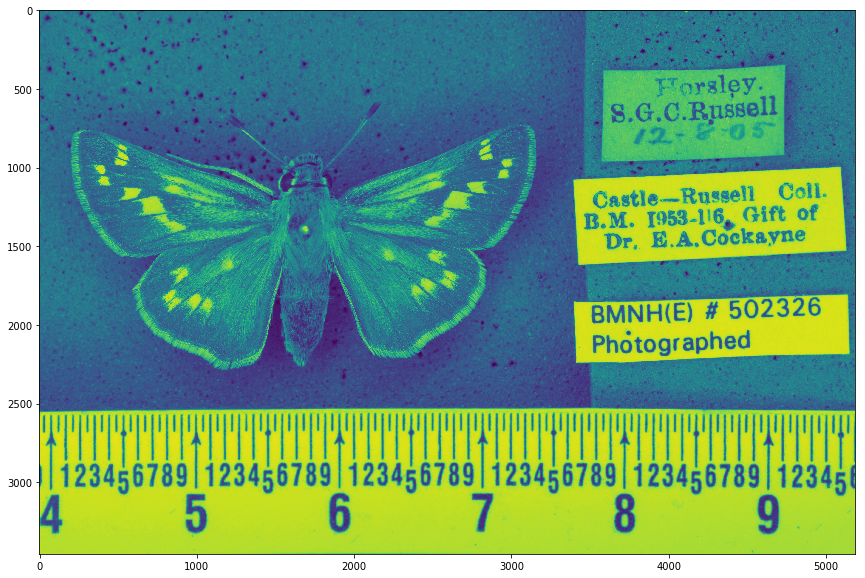

In [8]:

image_rgb = imread('pictures/BMNHE_502326.JPG')
image_gray = image_rgb[:, :, 0]
print('image shape :', image_gray.shape)
plt.imshow(image_gray);

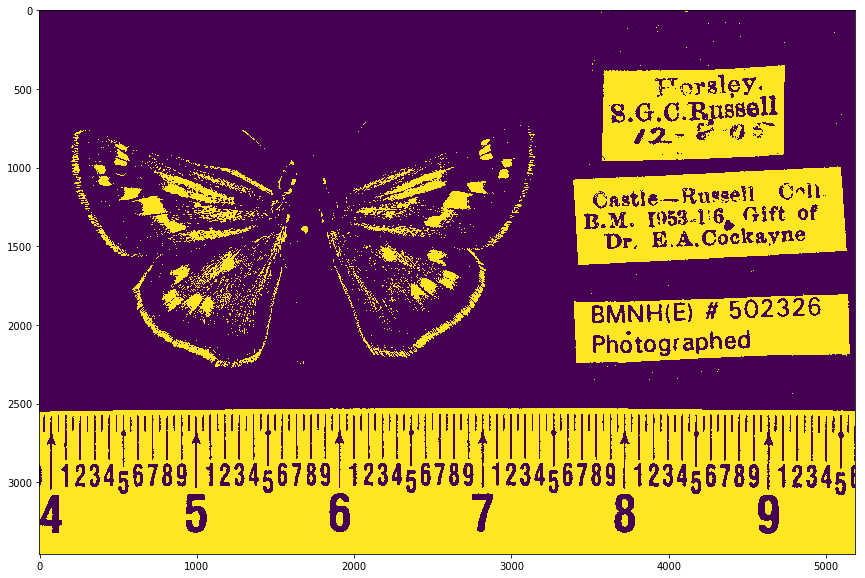

In [9]:
thresh = threshold_otsu(image_gray, nbins = 60)
binary = image_gray > thresh
plt.imshow(binary);

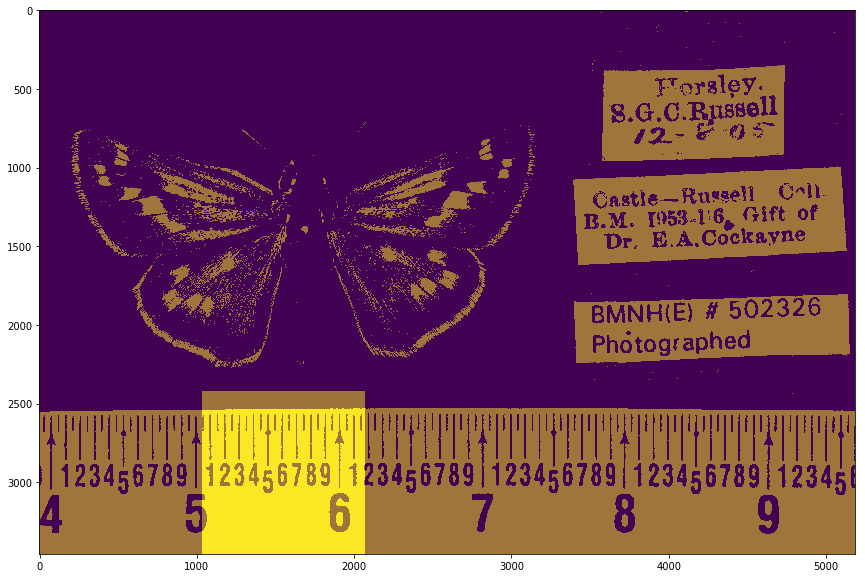

In [10]:
up_rectangle = int(binary.shape[0]*0.7)
left_rectangle = int(binary.shape[1]*0.2)
right_rectangle = int(binary.shape[1]*0.4)

rectangle = np.zeros((binary.shape[0], binary.shape[1]))
rectangle[up_rectangle:, left_rectangle: right_rectangle] = 1

plt.imshow(binary)
plt.imshow(rectangle, alpha=0.5);

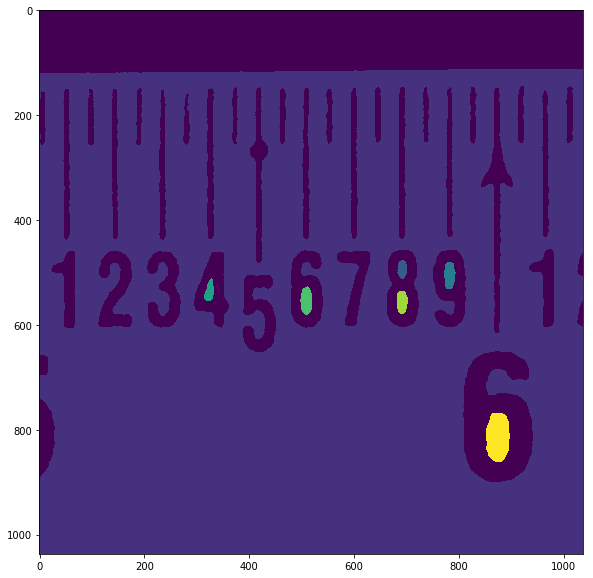

In [11]:
rectangle_binary = binary[up_rectangle:, left_rectangle: right_rectangle]
markers, nb_labels = ndi.label(rectangle_binary,
                       structure=ndi.generate_binary_structure(2,1))
plt.imshow(markers);

In [12]:
regions = regionprops(markers)
areas = []
for region in regions:
    areas.append(region.area)
    
idx_max = np.argmax(areas)
coords = regions[idx_max].coords
offset = np.min(coords[:, 0])
print('offset : %i pixels' %offset)


offset : 112 pixels


The offset is the distance in pixels between the top of the rectangle and the top of the ruler, now when know where the ruler is.

## 1.2 Finding distance between 2 ticks


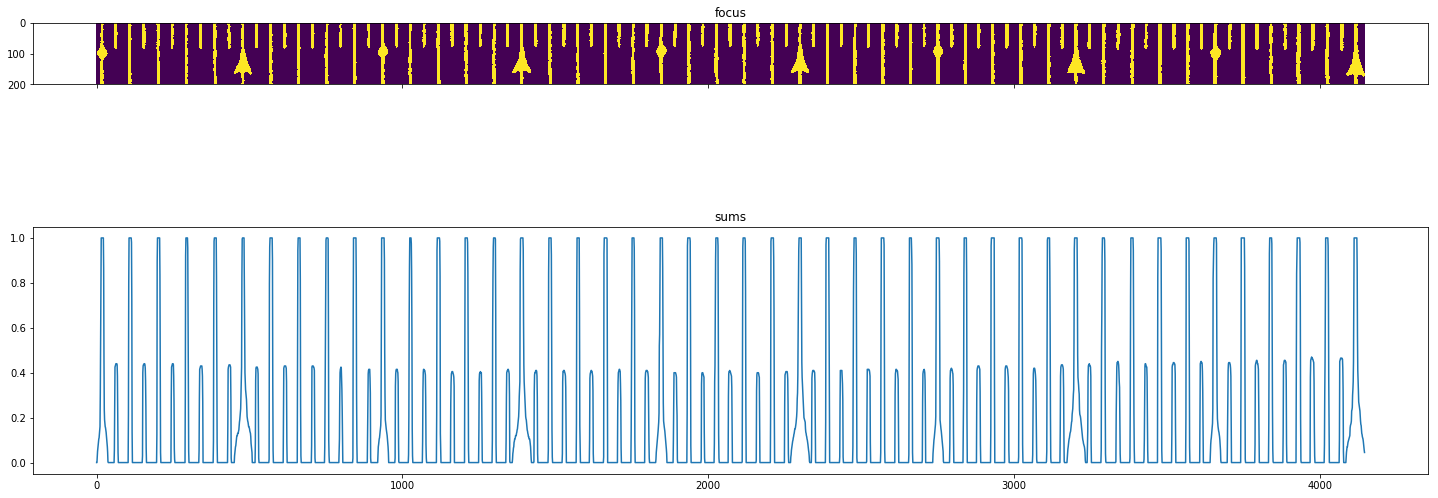

In [13]:
up_focus = up_rectangle + offset + 60
left_focus = int(binary.shape[1]*0.1)
right_focus = int(binary.shape[1]*0.9)
height_focus = 200
focus = ~binary[up_focus: up_focus + height_focus, left_focus: right_focus]

fig, ax = plt.subplots(2, sharex=True)
ax[0].imshow(focus)
ax[0].set_title('focus')

sums = np.sum(focus, axis=0)/height_focus
x = range(len(sums))

ax[1].plot(x, sums)
ax[1].set_title('sums');

We use Fourier transformation to extract the spacial period of this signal. We are looking for the coeff with the highest value (discarding the very first one).

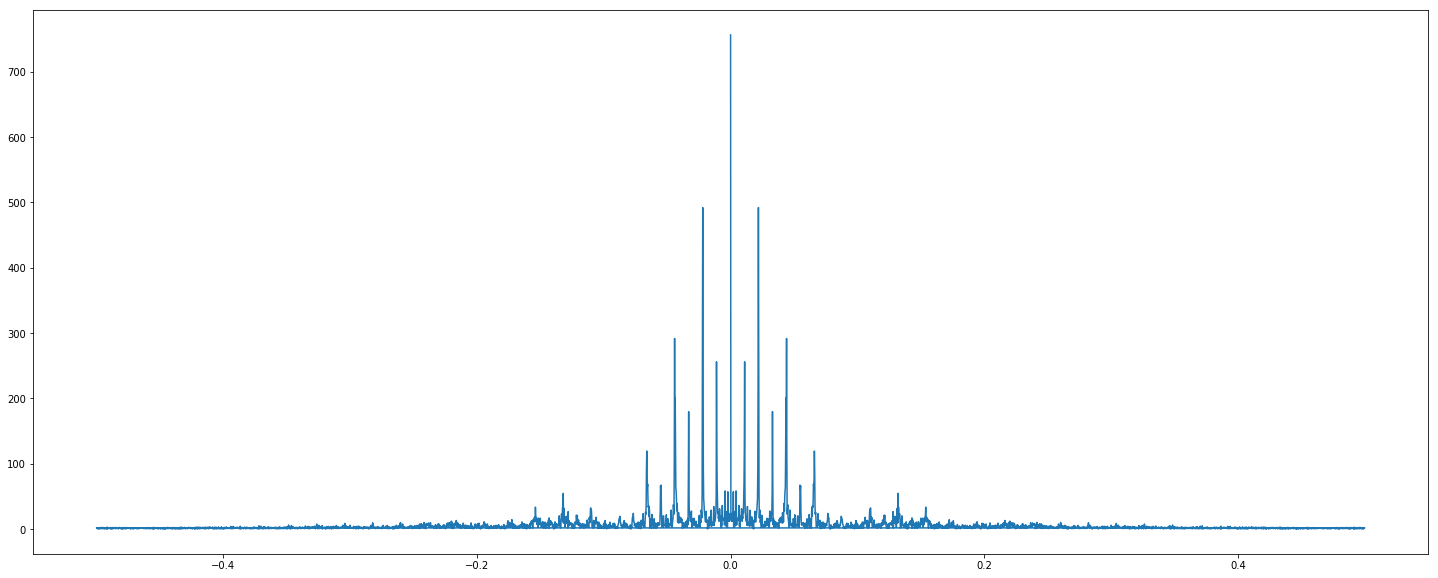

In [15]:
fourier = np.fft.fft(sums)
mod = [cmath.polar(el)[0] for el in fourier]
freq = np.fft.fftfreq(len(sums))
plt.plot(freq, mod);

In [16]:
idx_max = np.argmax(mod[1:]) + 1

print('idx_max = ', idx_max)
print('mod[idx_max] = ', mod[idx_max])

f_space = freq[idx_max] # nb patterns per pixel
T_space = 1/f_space
print('f_space : %f patterns/pixel' %round(f_space, 6))
print('T_space : %f pixels/pattern' %round(T_space, 6))


idx_max =  91
mod[idx_max] =  492.1924509126642
f_space : 0.021944 patterns/pixel
T_space : 45.571429 pixels/pattern


# 2 Wings measurement

(2359, 3500)


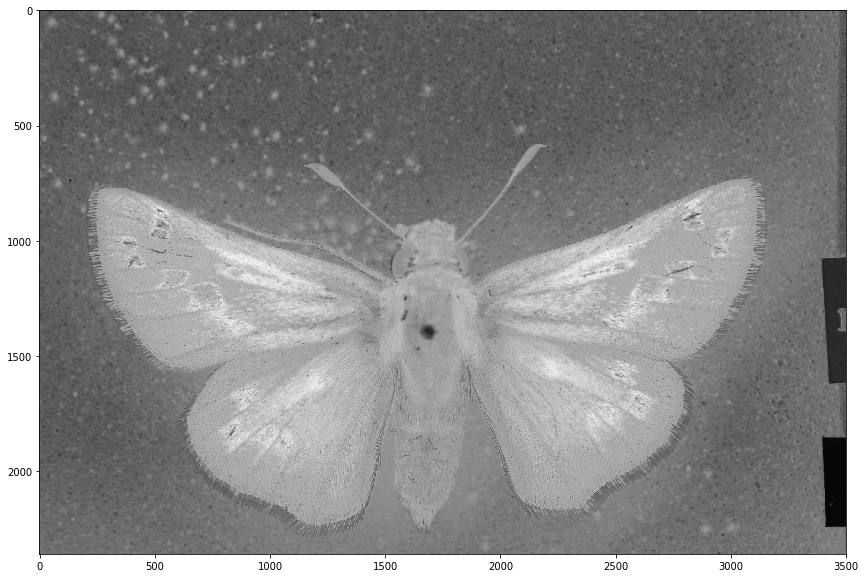

In [17]:
bfly_rgb = image_rgb[:up_rectangle - 60, :3500] # /!\ Magic number here
bfly_hed = color.rgb2hed(bfly_rgb)[:, :, 2]
print(bfly_hed.shape)
#print(bfly_lab[:10, :10])
plt.imshow(bfly_hed, plt.cm.gray);

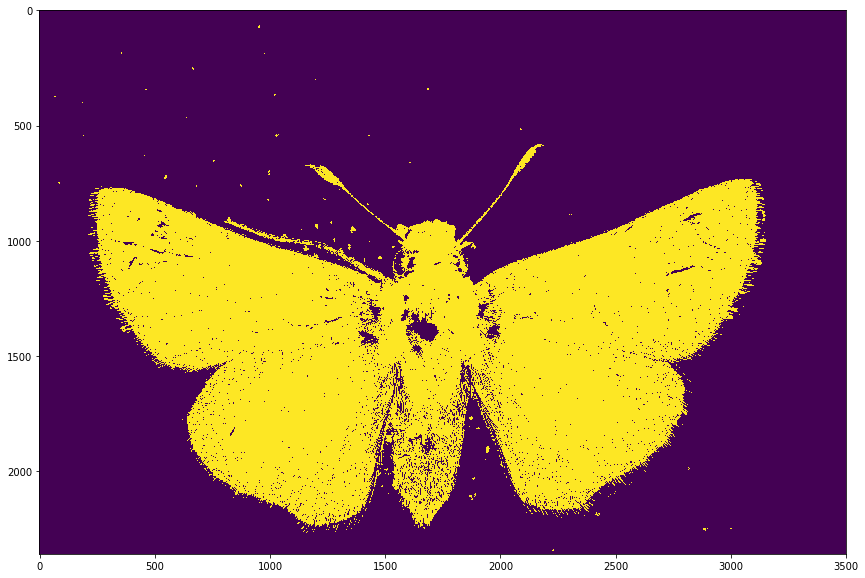

In [18]:
from skimage.exposure import rescale_intensity

rescaled = rescale_intensity(bfly_hed, out_range=(0, 255))
tresh = threshold_otsu(rescaled)
bfly_bin = rescaled > thresh
plt.imshow(bfly_bin);

divided.shape :  (2359, 3500)
half : 1750


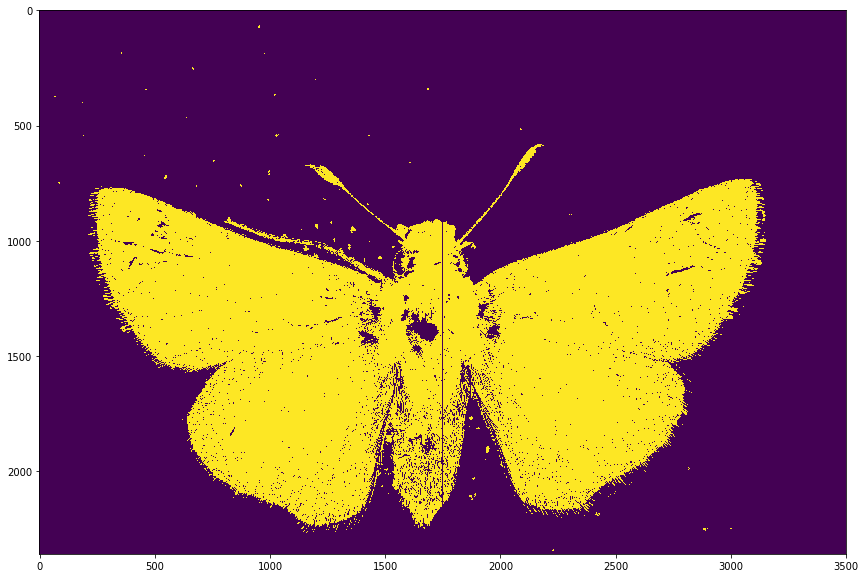

In [19]:
divided = np.copy(bfly_bin)
print('divided.shape : ',divided.shape)
half = int(divided.shape[1]/2)
print('half :', half)
divided[:, half] = 0
plt.imshow(divided);

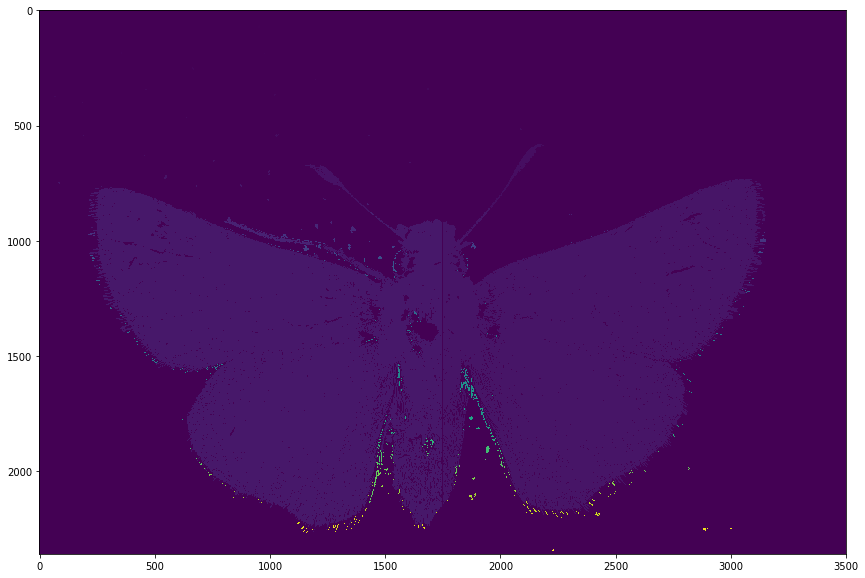

In [20]:
markers_divided, _ = ndi.label(divided,
                       structure=ndi.generate_binary_structure(2,1))
regions = regionprops(markers_divided)
areas = []
for region in regions:
    areas.append(region.area)
    
idx_1 = np.argmax(areas)
coords1 = regions[idx_1].coords
areas[idx_1] = 0
idx_2 = np.argmax(areas)
coords2 = regions[idx_2].coords
plt.imshow(markers_divided);

up left : [769 282]
down left : [2264 1189]
up right : [ 732 3087]
down right : [2190 2190]
dist_l_pix : 1748.62
dist_r_pix : 1711.83
dist_l_mm : 19.190000 mm
dist_r_mm : 18.780000 mm


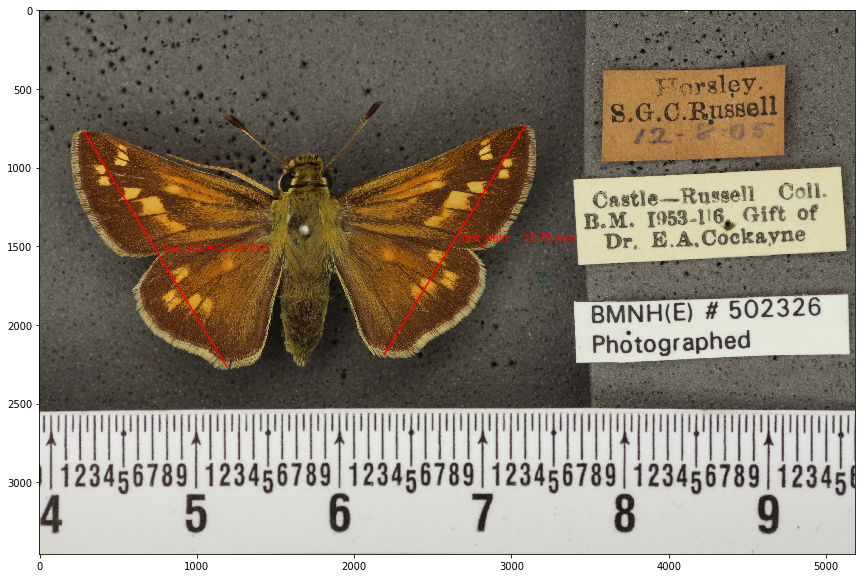

In [22]:
if np.min(coords1[:, 1]) < np.min(coords2[:, 1]):
    coords_l, coords_r = coords1, coords2
else:
    coords_l, coords_r = coords2, coords1
    
idx_up_l = np.argmin(coords_l[:, 0])
idx_down_l = np.argmax(coords_l[:, 0])
up_l = coords_l[idx_up_l]
down_l = coords_l[idx_down_l]

idx_up_r = np.argmin(coords_r[:, 0])
idx_down_r = np.argmax(coords_r[:, 0])
up_r = coords_r[idx_up_r]
down_r = coords_r[idx_down_r]

print('up left :', up_l)
print('down left :', down_l)
print('up right :', up_r)
print('down right :', down_r)

dist_r_pix = np.sqrt((up_r[0]-down_r[0])**2 + (up_r[1]-down_r[1])**2)
dist_l_pix = np.sqrt((up_l[0]-down_l[0])**2 + (up_l[1]-down_l[1])**2)

print( 'dist_l_pix :', round(dist_l_pix, 2))
print( 'dist_r_pix :', round(dist_r_pix, 2))

dist_l_mm = dist_l_pix/(2*T_space)
dist_r_mm = dist_r_pix/(2*T_space)

print( 'dist_l_mm : %f mm' %round(dist_l_mm, 2))
print( 'dist_r_mm : %f mm' %round(dist_r_mm, 2))

fig, ax = plt.subplots()
ax.imshow(image_rgb)
ax.plot([up_l[1], down_l[1]], [up_l[0], down_l[0]], color='r')
ax.plot([up_r[1], down_r[1]], [up_r[0], down_r[0]], color='r')
ax.text(int((up_l[1] + down_l[1])/2) +50,
        int((up_l[0] + down_l[0])/2),
        'dist_left = ' + str(round(dist_l_mm, 2)) +' mm',
        color='r')
ax.text(int((up_r[1] + down_r[1])/2) +50,
        int((up_r[0] + down_r[0])/2),
        'dist_right = ' + str(round(dist_r_mm, 2)) +' mm',
        color='r');

# Conclusions

1) We were lucky in this case because the antennas are disconnected from the rest of the body in the binary image. So we need to find a way to make sure the top left and top right pixels are not part of the antennas. 

2) We have to find a way to crop the butterfly properly, I used the magic number "3500" here, which needs changing. We could implement that the same way we detected the top of the ruler.

3) We need a better way to split the butterfly in half, not just cutting the frame in the middle. 

4) The distances extracted here are not the good ones, we could use some boundary tracing there to detect the top of the junctions between the body and the wings.